In [107]:
# Imports principales para manipulación de datos, visualización y modelado
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de scikit-learn para entrenamiento y evaluación
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Detectar automáticamente la raíz del proyecto (donde existe la carpeta src)
PROJECT_DIR = Path.cwd().resolve()
while PROJECT_DIR != PROJECT_DIR.parent and not (PROJECT_DIR / "src").exists():
    PROJECT_DIR = PROJECT_DIR.parent
sys.path.insert(0, str(PROJECT_DIR))

from src.config import SEED, TEST_SIZE, VAL_SIZE
from src.utils.seeds import set_seeds
from src.paths import DATA_RAW

set_seeds(SEED)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

## EDA

In [108]:
#Carga inicial de datos
orders = pd.read_csv(DATA_RAW / "olist_orders_dataset.csv")
orders_df = orders.copy()
print(f"Cantidad de columnas {orders_df.shape[1]} \nCantidad de filas {orders_df.shape[0]}")
display(orders_df.head())
print(orders_df.info())

Cantidad de columnas 8 
Cantidad de filas 99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None


### Observacion y limpieza de datos

In [109]:
# Conversión segura de columnas de fecha a datetime
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    orders_df[col] = pd.to_datetime(orders_df[col], errors="coerce")

In [110]:
# Análisis de valores faltantes
falatantes = orders_df.isnull().sum().sort_values(ascending= False)
display(falatantes.to_frame("Valores faltantes"))

# Eliminación de filas con fechas faltantes
orders_df = orders_df.dropna()

falatantes = orders_df.isnull().sum().sort_values(ascending= False)
display(falatantes.to_frame("Valores faltantes"))
display(orders_df.info())

,Valores faltantes
order_delivered_customer_date,2965
order_delivered_carrier_date,1783
order_approved_at,160
order_id,0
order_purchase_timestamp,0
order_status,0
customer_id,0
order_estimated_delivery_date,0


,Valores faltantes
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,0
order_delivered_carrier_date,0
order_delivered_customer_date,0
order_estimated_delivery_date,0


<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96461 non-null  datetime64[ns]
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


None

In [111]:
# Se mira cuantos datos hay de cada categoria de order_status ya que no todos los items fueron entegados
orders_df["order_status"].value_counts()


order_status
delivered    96455
canceled         6
Name: count, dtype: int64

In [112]:
# Solo los pedidos entregados permiten medir tiempo real de entrega.
orders_delivered = orders_df[orders_df["order_status"] == "delivered"].copy()
orders_delivered.shape

(96455, 8)

### Construcción del TARGET (ETA)

In [113]:
# Tiempo total de entrega (en días)
orders_delivered["delivery_days"] = (
    orders_delivered["order_delivered_customer_date"]
    - orders_delivered["order_purchase_timestamp"]
).dt.days

count    96455.000000
mean        12.093100
std          9.551209
min          0.000000
1%           1.000000
5%           3.000000
25%          6.000000
50%         10.000000
75%         15.000000
95%         29.000000
99%         46.000000
max        209.000000
Name: delivery_days, dtype: float64

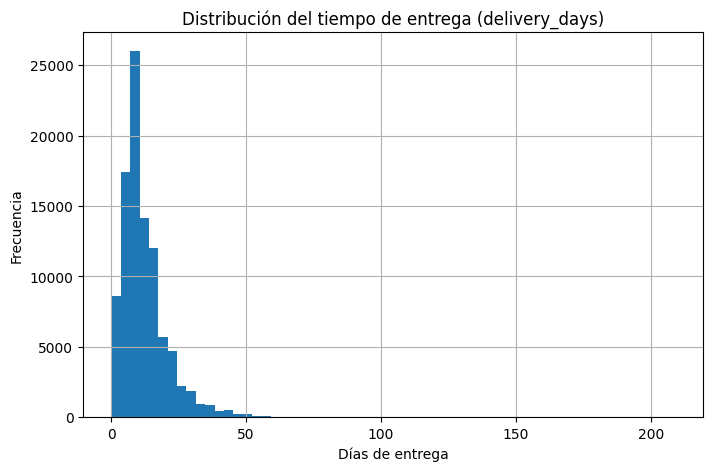

In [114]:
# Distribución y outliers
display(orders_delivered["delivery_days"].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))

plt.figure(figsize=(8,5))
orders_delivered["delivery_days"].hist(bins=60)
plt.xlabel("Días de entrega")
plt.ylabel("Frecuencia")
plt.title("Distribución del tiempo de entrega (delivery_days)")
plt.show()

In [115]:
#Limpieza de outliers extremos
low = orders_delivered["delivery_days"].quantile(0.01)
high = orders_delivered["delivery_days"].quantile(0.99)

orders_delivered = orders_delivered[
    (orders_delivered["delivery_days"] >= low) &
    (orders_delivered["delivery_days"] <= high)
]

orders_delivered["delivery_days"].describe()

count    95563.000000
mean        11.620271
std          7.809971
min          1.000000
25%          6.000000
50%         10.000000
75%         15.000000
max         46.000000
Name: delivery_days, dtype: float64

In [116]:
# Demora en aprobación (horas)
orders_delivered["approval_delay_h"] = (
    orders_delivered["order_approved_at"]
    - orders_delivered["order_purchase_timestamp"]
).dt.total_seconds() / 3600

# Tiempo estimado prometido (días)
orders_delivered["estimated_days"] = (
    orders_delivered["order_estimated_delivery_date"]
    - orders_delivered["order_purchase_timestamp"]
).dt.days

# Tiempo hasta carrier (horas)
orders_delivered["carrier_delay_h"] = (
    orders_delivered["order_delivered_carrier_date"]
    - orders_delivered["order_approved_at"]
).dt.total_seconds() / 3600

# Variables de calendario
orders_delivered["purchase_dow"] = orders_delivered["order_purchase_timestamp"].dt.dayofweek
orders_delivered["purchase_hour"] = orders_delivered["order_purchase_timestamp"].dt.hour
orders_delivered["purchase_month"] = orders_delivered["order_purchase_timestamp"].dt.month

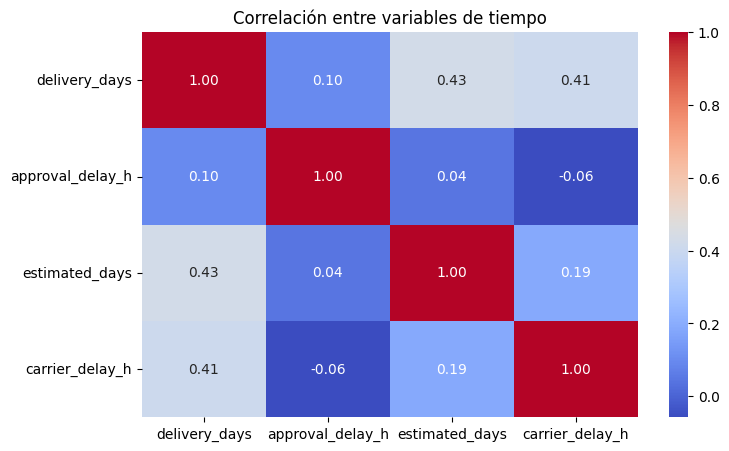

In [117]:
# Correlaciones
features_corr = [
    "delivery_days",
    "approval_delay_h",
    "estimated_days",
    "carrier_delay_h"
]

corr = orders_delivered[features_corr].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables de tiempo")
plt.show()

In [118]:
# Se asigna en X los Features (variables independientes) y en Y el target (variable dependiente )
X = orders_delivered[
    ["estimated_days", "carrier_delay_h", "approval_delay_h",
     "purchase_dow", "purchase_hour", "purchase_month"]
]

Y = orders_delivered["delivery_days"]


In [119]:
# Validación cruzada de modelos
models = {
    "LinearRegression": make_pipeline(StandardScaler(), LinearRegression()),
    "DecisionTree": DecisionTreeRegressor(random_state=SEED),
    "RandomForest": RandomForestRegressor(random_state=SEED, n_estimators=200),
    "GradientBoosting": GradientBoostingRegressor(random_state=SEED),
    "KNN": make_pipeline(StandardScaler(), KNeighborsRegressor())
}


cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

for name, model in models.items():
    scores = cross_val_score(
        model, X, Y,
        cv=cv,
        scoring="neg_mean_absolute_error"
    )
    print(f"{name}: MAE medio = {-scores.mean():.2f}")

LinearRegression: MAE medio = 4.60
DecisionTree: MAE medio = 5.95
RandomForest: MAE medio = 4.39
GradientBoosting: MAE medio = 4.27
KNN: MAE medio = 4.66


In [120]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=TEST_SIZE, random_state=SEED)
best_model = GradientBoostingRegressor(random_state=SEED)
best_model.fit(X_train, Y_train)

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(Y_test, y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 4.27
RMSE: 6.08


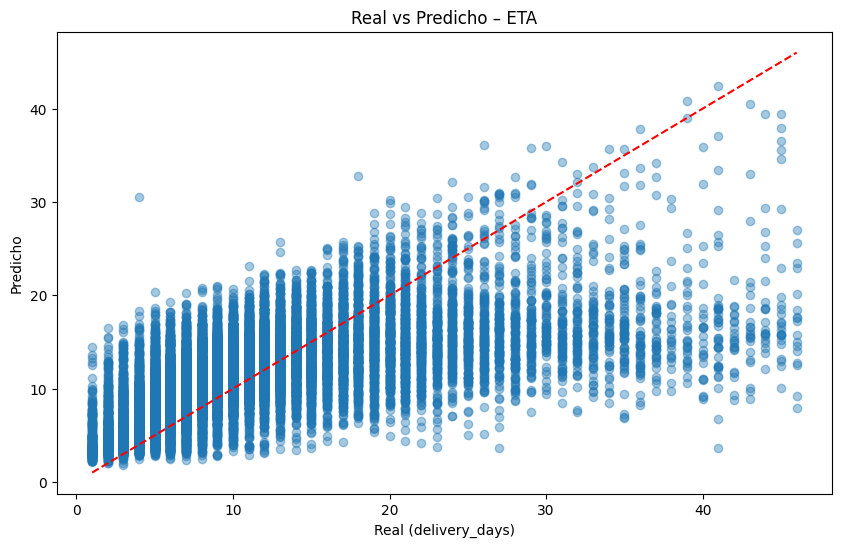

In [121]:
plt.figure(figsize=(10,6))
plt.scatter(Y_test, y_pred, alpha=0.4)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()], "r--")
plt.xlabel("Real (delivery_days)")
plt.ylabel("Predicho")
plt.title("Real vs Predicho – ETA")
plt.show()


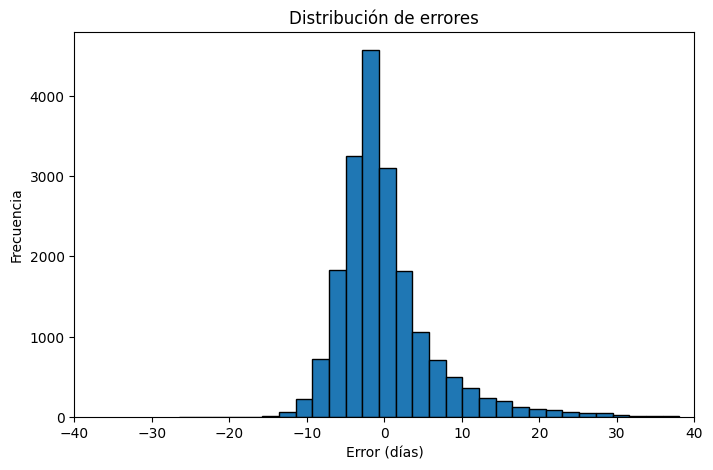

In [122]:
errors = Y_test - y_pred

plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor="black")
plt.xlabel("Error (días)")
plt.xlim(-40,40)
plt.ylabel("Frecuencia")
plt.title("Distribución de errores")
plt.show()


“Para la mayoría de los pedidos, el modelo predice razonablemente bien, pero falla más en casos extremos.”

In [123]:
r2 = r2_score(Y_test, y_pred)
print("R²:", r2)

R²: 0.3950328633934205
